In [1]:
cd ../src

/Users/phottovy/galvanize/04_Capstone_1/song_lyric_classifier/src


In [2]:
%matplotlib inline
import glob
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import nltk
# from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer
import itertools
import sys
import os.path
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from add_stop_words import add_stop_words, nltk_s_words
from tabulate import tabulate

In [3]:
plt.style.use('seaborn-darkgrid')
plt.rcParams["patch.force_edgecolor"] = True

In [4]:
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()
sksw = ENGLISH_STOP_WORDS
nltksw = nltk_s_words()
addsw = add_stop_words()

In [5]:
sw = sksw
lm = None
stm = None
mxf = None

In [6]:
# Create or import dataset
def get_data(artist='Bob Dylan', exact=False):
    '''
    Import or create a new a sample dataset
    '''
    location = '../data/'
    filename = artist.replace(' ', '_').lower()+'_sample_dataset.csv'
    loc_file = location + filename
    if os.path.isfile(loc_file):
        df = pd.read_csv(loc_file)
    else:
        df = create_dataset(artist, exact, location, loc_file)
    return df

In [7]:
def create_dataset(artist, exact, location, loc_file):
    '''
    Creates a sample dataset of from the 500K song
    lyric dataset for the specified band/artist
    along with a random sample of songs for comparison data.

    Parameters
    ----------
    band: name of artist or band to be used in your analysis
    exact: boolean, default False
        Whether to filter by an exact match or a string that 
        contains the inputted artist/band value

    Returns
    -------
    .csv file containing all of the songs of the specified
    artist and a random sample (minimum 50 songs) of other
    songs from the dataset.
    '''
    full_dataset = location + 'every-song-you-have-heard-almost/Lyrics*.csv'
    full_dataset = pd.concat(
        [pd.read_csv(f) for f in glob.glob(full_dataset)])
    full_dataset.drop_duplicates(
        ['Band', 'Song', 'Lyrics'], inplace=True)
    if exact:
        artist_dataset = full_dataset[full_dataset['Band'].str.match(
            artist, case=False)].copy()
    else:
        artist_dataset = full_dataset[full_dataset['Band'].str.contains(
            artist, case=False)].copy()
    artist_dataset.drop_duplicates('Lyrics', inplace=True)
    rand_dataset = full_dataset[~full_dataset['Band'].str.match(
        artist, case=False)].sample(max(len(artist_dataset), 50))
    artist_dataset['Test_Artist'] = 1
    rand_dataset['Test_Artist'] = 0
    sample_dataset = pd.concat(
        [artist_dataset, rand_dataset]).copy()
    del full_dataset, artist_dataset, rand_dataset
    sample_dataset.to_csv(loc_file, index=False)
    return sample_dataset

In [8]:
def clean_full_dataset(dataset, stopwords=sksw, lemm=None, stem=None):
    '''
    Cleans the 'Lyrics' column from the master dataset.
    Returns a new dataframe and series containing the clean lyrics.
    '''
    clean_dataset = dataset.copy()
    clean_dataset['Lyrics'] = clean_strip_lyrics(
        clean_dataset['Lyrics'], stopwords, lemm, stem)
    clean_lyrics = clean_dataset['Lyrics']
    return clean_dataset, clean_lyrics

In [9]:
def clean_strip_lyrics(dataset, stopwords=sksw, lemm=None, stem=None):
    '''
    Strip punctuation and cleans the word list

    Steps
    -----
    1. remove punctuation
    2. remove stopwords from provided dictionary, default sksw list
        'all' for a combination of three sets of stopwords
    3. stem word list, default None
    4. lemmatize word list, default None
    5. return list of clean word list from lyrics

    Parameters
    ----------
    lyrics: string of lyrics to be cleaned
    stopwords: dictionary of stopwords to exclude from model, default sksw from sklearn
    '''
    if stopwords == 'all':
        stopwords = combine_stopwords()
    rm_punct = [''.join(
        [char for char in word if char not in string.punctuation]) for word in dataset]
    rm_stop = [[word.lower() for word in words.split()if word.lower()
                not in stopwords] for words in rm_punct]
    if lemm == wordnet:
        rm_lemm = [[wordnet.lemmatize(word)
                    for word in words] for words in rm_stop]
    else:
        rm_lemm = rm_stop
    if stem == porter:
        rm_stem = [[porter.stem(word) for word in words] for words in rm_lemm]
    elif stem == snowball:
        rm_stem = [[snowball.stem(word) for word in words]
                   for words in rm_lemm]
    else:
        rm_stem = rm_lemm
    clean_lyrics = [' '.join([word for word in words]) for words in rm_stem]
    return pd.Series(clean_lyrics)

In [10]:
def combine_stopwords():
    return set(list(sksw) + nltksw + addsw)

In [11]:
allsw = combine_stopwords
full_dataset = get_data()
clean_dataset, clean_lyrics = clean_full_dataset(full_dataset, stopwords=sw, lemm=lm, stem=stm)

In [12]:
# pipeline for the model
def set_pipeline(X, y, max_feats=None):
    lyrics_pipeline = Pipeline([
        ('convert_lyrics', CountVectorizer(max_features=max_feats)),
        ('tf-idf', TfidfTransformer()),
        ('naive_bayes', MultinomialNB())
    ])
    return lyrics_pipeline.fit(X, y)

In [13]:
# split data between test and training data
def data_test_train_split(dataset, X_col='Lyrics', y_col='Test_Artist', size=0.3):
    '''
    Splits the dataset into training and test sets.
    '''
    X_train, X_test, y_train, y_test = train_test_split(
        dataset[X_col], dataset[y_col], test_size=size)
    return X_train, X_test, y_train, y_test

In [14]:
def make_predictions(pipeline, X_test):
    '''
    Makes predictions of y values based on the model.
    '''
    return pipeline.predict(X_test)

In [15]:
def bag_of_words_counts(lyrics=clean_lyrics, n_samples=20, max_feats=mxf):
    '''
    Returns the nth most common words in the dataset
    '''
    sum_words = np.asarray(CountVectorizer(max_features=max_feats).fit_transform(
        lyrics).sum(axis=0)).ravel().tolist()
    counts_df = pd.DataFrame({'word': CountVectorizer(max_features=max_feats).fit(
        lyrics).get_feature_names(), 'count': sum_words})
    sort_df = counts_df.sort_values(
        by='count', ascending=False).reset_index(drop=True)
    sort_df.index = np.arange(1, len(counts_df)+1)
    print(tabulate(sort_df.head(n_samples),
                   headers=counts_df.columns, tablefmt='pipe'))
    return sort_df.head(n_samples)

In [16]:
def sparse_matrix(lyrics=clean_lyrics, max_feats=mxf):
    '''
    Prints the features of the bag of words sparse matrix.
    '''
    vect = CountVectorizer(max_features=max_feats).fit_transform(lyrics)
    sparsity = (100.0 * vect.nnz / (vect.shape[0] * vect.shape[1]))
    print(f'Shape of Sparse Matrix: {vect.shape}')
    print(f'Amount of Non-Zero occurences: {vect.nnz}')
    print(f'Sparcity of Matrix: {sparsity:.3f}')

In [17]:
# TF-IDF calculations
def tfidf_counts(lyrics=clean_lyrics, n_samples=20, max_feats=mxf):
    '''
    Returns the nth highest weighted words in the dataset
    '''
    tfidf_weights = TfidfVectorizer(
        max_features=max_feats).fit_transform(lyrics)
    weights = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'word': TfidfVectorizer(max_features=max_feats).fit(
        lyrics).get_feature_names(), 'weight': weights})
    sort_df = weights_df.sort_values(
        by='weight', ascending=False).reset_index(drop=True)
    sort_df.index = np.arange(1, len(weights_df)+1)
    print(tabulate(sort_df.head(n_samples),
                   headers=weights_df.columns, tablefmt='pipe'))
    return sort_df.head(n_samples)

In [18]:
def sample_vectors(lyrics=clean_lyrics, n_samples=5, max_feats=mxf):
    '''
    Display a sample bow and tf-idf matrix from n songs. Max 10.
    '''
    samp_lyrics = lyrics.sample(min(n_samples, 10))
    bow_data = CountVectorizer(max_features=max_feats).fit_transform(samp_lyrics).toarray()
    bow_cols = CountVectorizer(max_features=max_feats).fit(samp_lyrics).get_feature_names()
    bow_df = pd.DataFrame(data=bow_data, columns=bow_cols)
    print(tabulate(bow_df.iloc[:, :10], headers=bow_df.columns, tablefmt='pipe'))
    
    
    pd.options.display.float_format = '{0:.2%}'.format
    tfidf_data = TfidfVectorizer(max_features=max_feats).fit_transform(samp_lyrics).toarray()
    tfidf_cols = TfidfVectorizer(max_features=max_feats).fit(samp_lyrics).get_feature_names()
    tfidf_df = pd.DataFrame(data=tfidf_data, columns=tfidf_cols)
    print(tabulate(tfidf_df.iloc[:, :10], headers=tfidf_df.columns, tablefmt='pipe'))
    return bow_df, tfidf_df

In [19]:
# Calculate Results
def print_classification_info(y_test, y_predict):
    cols = ['Statistic', 'Result']
    acc = ['Accuracy', '{:.4f}'.format(metrics.accuracy_score(y_test, y_predict))]   
    pre = ['Precision', '{:.4f}'.format(metrics.precision_score(y_test, y_predict))]
    rec = ['Recall', '{:.4f}'.format(metrics.recall_score(y_test, y_predict))]
    f1 = ['F1-Score', '{:.4f}'.format(metrics.f1_score(y_test, y_predict))]                                  
    print('Classification Statistics:\n')
    print(tabulate([cols, acc, pre, rec, f1], headers='firstrow', tablefmt='pipe'))       
    


In [20]:
def confuse_matrix(y_test, y_predict):
    '''
    Creates a confusion matrix. It flips the order of
    Sklearn's built in function.
    '''
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict).ravel()
    cm_arr = np.array([[tp, fn], [fp, tn]])
    return cm_arr

In [21]:
def confusion_matrix_plot(y_test, y_predict, save_fig=False, cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    '''
    cm = confuse_matrix(y_test, y_predict)
    classes = ['True', 'False']
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid(b=None)
    plt.title('Confusion Matrix', fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    if save_fig:
        plt.savefig('confusion_matrix.png')
    plt.show()

In [22]:
def roc_curve_plot(y_test, y_probs, save_fig=False):
    '''
    This function prints and plots the ROC plot.
    '''
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', linewidth=2)
    plt.plot([0,1], [0,1], linestyle='--', lw=2, color='r')
    plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=14)
    plt.ylabel("True Positive Rate (Sensitivity, Recall)", fontsize=14)
    plt.title("ROC plot", fontsize=20)
    plt.legend()
    if save_fig:
        plt.savefig('roc_plot.png')
    plt.show();

In [23]:
# if __name__ == '__main__':

full_dataset = get_data()
clean_dataset, clean_lyrics = clean_full_dataset(full_dataset, stopwords=sw, lemm=lm, stem=stm)
X_train, X_test, y_train, y_test = data_test_train_split(clean_dataset)
lyrics_pipeline = set_pipeline(X_train, y_train, max_feats=mxf)
y_predictions = make_predictions(lyrics_pipeline, X_test)
y_probs = lyrics_pipeline.predict_proba(X_test)[:,1]
print_classification_info(y_test, y_predictions)

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.7035 |
| Precision   |   0.6751 |
| Recall      |   0.829  |
| F1-Score    |   0.7442 |


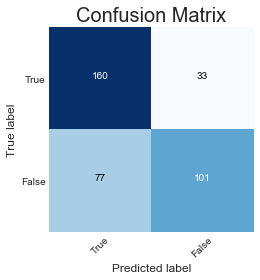

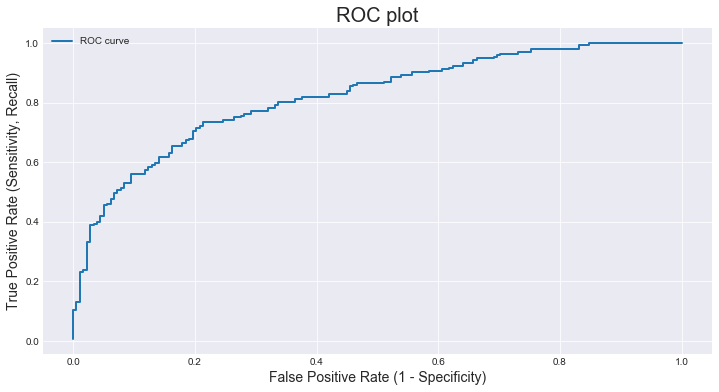

In [24]:
confusion_matrix_plot(y_test, y_predictions, save_fig=False)
roc_curve_plot(y_test, y_probs, save_fig=False)

In [25]:
bag_of_words_counts(n_samples=10, max_feats=mxf)

|    | word   |   count |
|---:|:-------|--------:|
|  1 | im     |    1961 |
|  2 | dont   |    1673 |
|  3 | love   |    1470 |
|  4 | like   |    1435 |
|  5 | just   |    1433 |
|  6 | know   |    1390 |
|  7 | got    |    1180 |
|  8 | oh     |     986 |
|  9 | come   |     917 |
| 10 | youre  |     871 |


,word,count
1,im,1961
2,dont,1673
3,love,1470
4,like,1435
5,just,1433
6,know,1390
7,got,1180
8,oh,986
9,come,917
10,youre,871


In [26]:
sparse_matrix(max_feats=mxf)

Shape of Sparse Matrix: (1234, 15017)
Amount of Non-Zero occurences: 84326
Sparcity of Matrix: 0.455


In [27]:
tfidf_counts(n_samples=10, max_feats=mxf)

|    | word   |    weight |
|---:|:-------|----------:|
|  1 | im     | 0.0372485 |
|  2 | love   | 0.0351997 |
|  3 | dont   | 0.0337922 |
|  4 | know   | 0.0276959 |
|  5 | just   | 0.0270098 |
|  6 | like   | 0.0257696 |
|  7 | baby   | 0.0229618 |
|  8 | got    | 0.0229544 |
|  9 | oh     | 0.0225686 |
| 10 | come   | 0.0216899 |


,word,weight
1,im,0.037248
2,love,0.035200
3,dont,0.033792
4,know,0.027696
5,just,0.027010
6,like,0.025770
7,baby,0.022962
8,got,0.022954
9,oh,0.022569
10,come,0.021690


In [28]:
bow_df, tfidf_df = sample_vectors(max_feats=mxf)

|   advice |   aeroplano |   ahora |   al |   alive |   almidonado |   aterrizo |   aviso |   away |   años |   baby |
|---------:|------------:|--------:|-----:|--------:|-------------:|-----------:|--------:|-------:|-------:|-------:|
|        0 |           1 |       0 |    0 |       0 |            0 |          0 |       0 |      0 |      0 |      0 |
|        1 |           0 |       0 |    0 |       0 |            1 |          0 |       0 |      0 |      0 |      0 |
|        2 |           0 |       3 |    4 |       2 |            0 |          1 |       3 |      2 |      0 |      2 |
|        3 |           0 |       0 |    0 |       0 |            0 |          0 |       0 |      0 |     18 |      0 |
|        4 |           0 |       0 |    0 |       0 |            0 |          0 |       0 |      0 |      1 |      0 |
|   advice |   aeroplano |   ahora |       al |     alive |   almidonado |   aterrizo |   aviso |      away |      años |      baby |
|---------:|------------:|-------

In [29]:
bow_df

,advice,aeroplano,ahora,al,alive,almidonado,aterrizo,aviso,away,años,...,way,weep,weve,white,wide,wonder,wonderful,worry,years,youre
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,7,0,3,0,0,0,2,1,0,3
2,0,3,4,2,0,1,3,2,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,18,0,...,0,0,0,1,6,0,0,0,2,0
4,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1


In [30]:
tfidf_df

,advice,aeroplano,ahora,al,alive,almidonado,aterrizo,aviso,away,años,...,way,weep,weve,white,wide,wonder,wonderful,worry,years,youre
0,7.82%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
1,0.00%,0.00%,0.00%,0.00%,4.34%,0.00%,0.00%,0.00%,0.00%,0.00%,...,30.37%,0.00%,13.02%,0.00%,0.00%,0.00%,8.68%,4.34%,0.00%,10.50%
2,0.00%,11.77%,15.69%,7.84%,0.00%,3.92%,11.77%,7.84%,0.00%,7.84%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,61.99%,0.00%,...,0.00%,0.00%,0.00%,4.27%,25.61%,0.00%,0.00%,0.00%,8.54%,0.00%
4,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,6.88%,0.00%,...,0.00%,8.52%,0.00%,0.00%,0.00%,8.52%,0.00%,0.00%,0.00%,6.88%
